In [1]:
!pip install -q torch torchvision transformers scikit-learn seaborn streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 136.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# 1.2) Core imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from PIL import Image, ImageOps
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.calibration import calibration_curve

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from transformers import (
    ViTModel, ViTConfig,
    BertModel,
    AutoTokenizer
)

In [3]:
import torch
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))

True NVIDIA A100-SXM4-40GB


# Dataset Preparation

Download VQA-RAD image files and JSON Q/A annotations into data/.

Parse the JSON to build a DataFrame of (image_path, question, answer).

In [4]:
# 1) Install the HF datasets library
!pip install datasets


In [5]:
!rm -rf ~/.cache/huggingface/datasets/flaviagiammarino--vqa-rad


In [7]:
# move the token into place
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# install Kaggle support
!pip install -q kaggle


In [8]:
# this will fetch & unzip into data/vqa-rad
!kaggle datasets download -d shashankshekhar1205/vqa-rad-visual-question-answering-radiology \
    -p data/ --unzip


Dataset URL: https://www.kaggle.com/datasets/shashankshekhar1205/vqa-rad-visual-question-answering-radiology
License(s): apache-2.0
  0% 0.00/16.1M [00:00<?, ?B/s]
100% 16.1M/16.1M [00:00<00:00, 1.18GB/s]


In [9]:
# Replace the folder name below with whatever you saw above
from pathlib import Path
base = Path('/content/data/VQA_RAD Image Folder')

print("Contents of", base)
for p in sorted(base.iterdir()):
    print(" ", p.name)


Contents of /content/data/VQA_RAD Image Folder
  synpic100132.jpg
  synpic100176.jpg
  synpic100228.jpg
  synpic12210.jpg
  synpic13385.jpg
  synpic15006.jpg
  synpic16170.jpg
  synpic16174.jpg
  synpic16221.jpg
  synpic16407.jpg
  synpic16520.jpg
  synpic16810.jpg
  synpic17145.jpg
  synpic17153.jpg
  synpic17664.jpg
  synpic17675.jpg
  synpic17693.jpg
  synpic17738.jpg
  synpic17848.jpg
  synpic18250.jpg
  synpic18319.jpg
  synpic18461.jpg
  synpic18651.jpg
  synpic18896.jpg
  synpic19114.jpg
  synpic19118.jpg
  synpic19232.jpg
  synpic19477.jpg
  synpic19605.jpg
  synpic19782.jpg
  synpic19853.jpg
  synpic20208.jpg
  synpic20260.jpg
  synpic20375.jpg
  synpic20626.jpg
  synpic21028.jpg
  synpic21037.jpg
  synpic21042.jpg
  synpic21044.jpg
  synpic21410.jpg
  synpic21604.jpg
  synpic21700.jpg
  synpic21734.jpg
  synpic21776.jpg
  synpic21902.jpg
  synpic21995.jpg
  synpic22020.jpg
  synpic22037.jpg
  synpic22097.jpg
  synpic22156.jpg
  synpic22286.jpg
  synpic22310.jpg
  synpic22684.

In [10]:
import json
from pathlib import Path

data_dir = Path('/content/data')
print("Files in /content/data:")
for p in data_dir.iterdir():
    print(" ", p.name)

json_path = data_dir / 'VQA_RAD Dataset Public.json'
with open(json_path, 'r') as f:
    data = json.load(f)

print("\nType of loaded JSON:", type(data))
if isinstance(data, dict):
    print("Keys:", list(data.keys()))
elif isinstance(data, list):
    print("List length:", len(data))
    print("First item keys:", data[0].keys())


Files in /content/data:
  Readme.docx
  VQA_RAD Dataset Public.xml
  VQA_RAD Image Folder
  VQA_RAD Dataset Public.json
  VQA_RAD Dataset Public.xlsx

Type of loaded JSON: <class 'list'>
List length: 2248
First item keys: dict_keys(['qid', 'phrase_type', 'qid_linked_id', 'image_case_url', 'image_name', 'image_organ', 'evaluation', 'question', 'question_rephrase', 'question_relation', 'question_frame', 'question_type', 'answer', 'answer_type'])


In [11]:
import json
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

# 1) Point at your data folder and image folder
data_dir  = Path('/content/data')
json_file = data_dir / 'VQA_RAD Dataset Public.json'
img_dir   = data_dir / 'VQA_RAD Image Folder'

# 2) Load the JSON (a list of dicts)
with open(json_file, 'r') as f:
    data = json.load(f)

# 3) Build one record per entry (each already is a QA pair)
records = []
for entry in data:
    img_name  = entry['image_name']      # e.g. 'synpic100132.jpg'
    question  = entry['question']        # your question text
    answer    = entry['answer']          # your answer text

    # full path to the image
    img_path = img_dir / img_name

    records.append({
        'image_path': str(img_path),
        'question':    question,
        'answer':      answer
    })

df = pd.DataFrame(records)
print("Total samples:", len(df))

# 4) Split into train/test (80/20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train: {len(train_df)} samples\nTest:  {len(test_df)} samples")

# 5) Peek at the head
train_df.head()


Total samples: 2248
Train: 1798 samples
Test:  450 samples


,image_path,question,answer
478,/content/data/VQA_RAD Image Folder/synpic19118...,Are these small opacities in the right lung ca...,No
2166,/content/data/VQA_RAD Image Folder/synpic18896...,Is the patient's heart enlarged?,No
2098,/content/data/VQA_RAD Image Folder/synpic44995...,Is this a vascular lesion,Yes
2209,/content/data/VQA_RAD Image Folder/synpic51212...,What is the lesion in this image?,ring-enhancing lesion
736,/content/data/VQA_RAD Image Folder/synpic32962...,Doe this image depict an interstitial lung pro...,yes


In [12]:
from pathlib import Path

# 1) Create an output folder
out_dir = Path('/content/data/vqa_splits')
out_dir.mkdir(exist_ok=True)

# 2) Save to CSV
train_df.to_csv(out_dir / 'train.csv', index=False)
test_df.to_csv(out_dir  / 'test.csv',  index=False)

# 3) (Optional) also save as JSON
train_df.to_json(out_dir / 'train.json', orient='records', indent=2)
test_df.to_json(out_dir  / 'test.json',  orient='records', indent=2)

print("Files written to:", out_dir)
print(list(out_dir.iterdir()))


Files written to: /content/data/vqa_splits
[PosixPath('/content/data/vqa_splits/train.json'), PosixPath('/content/data/vqa_splits/test.json'), PosixPath('/content/data/vqa_splits/test.csv'), PosixPath('/content/data/vqa_splits/train.csv')]


In [13]:
# 6) Reload your train/test splits
import pandas as pd
from pathlib import Path

splits_dir = Path('/content/data/vqa_splits')
train_df = pd.read_csv(splits_dir / 'train.csv')
test_df  = pd.read_csv(splits_dir / 'test.csv')

print(f"Train rows: {len(train_df)}, Test rows: {len(test_df)}")
train_df.head()


Train rows: 1798, Test rows: 450


,image_path,question,answer
0,/content/data/VQA_RAD Image Folder/synpic19118...,Are these small opacities in the right lung ca...,No
1,/content/data/VQA_RAD Image Folder/synpic18896...,Is the patient's heart enlarged?,No
2,/content/data/VQA_RAD Image Folder/synpic44995...,Is this a vascular lesion,Yes
3,/content/data/VQA_RAD Image Folder/synpic51212...,What is the lesion in this image?,ring-enhancing lesion
4,/content/data/VQA_RAD Image Folder/synpic32962...,Doe this image depict an interstitial lung pro...,yes


In [14]:
# 2.1) Identify the top‐50 answers in train set
from collections import Counter

N = 50
answer_counts = Counter(train_df['answer'])
topN_answers = [ans for ans, _ in answer_counts.most_common(N)]
print("Top‐50 answers (sample):", topN_answers[:10], "...")

# 2.2) Create a new column 'answer2' that is either in topN or "other"
train_df['answer2'] = train_df['answer'].where(
    train_df['answer'].isin(topN_answers), 'other'
)
test_df['answer2'] = test_df['answer'].where(
    test_df['answer'].isin(topN_answers), 'other'
)

# 2.3) Check distribution of the new labels
new_counts = Counter(train_df['answer2'])
print("Top classes after collapsing:", new_counts.most_common(10))


Top‐50 answers (sample): ['No', 'Yes', 'yes', 'no', 'Axial', 'Right', 'Left', 'axial', 'CT', 'PA'] ...
Top classes after collapsing: [('other', 589), ('No', 394), ('Yes', 280), ('yes', 190), ('no', 98), ('Axial', 18), ('Right', 16), ('Left', 13), ('axial', 13), ('CT', 11)]


# Build Answer Vocabulary

In [15]:
# 7) Build answer vocabulary (top-500 + <unk>)
from collections import Counter

ans_counts = Counter(train_df['answer'])
top500 = [ans for ans,_ in ans_counts.most_common(500)]
answer2id = {ans:i for i,ans in enumerate(top500)}
answer2id['<unk>'] = len(answer2id)
id2answer = {i:ans for ans,i in answer2id.items()}

print("Number of classes:", len(answer2id))


Number of classes: 492


In [14]:
# 3.1) Create a list of labels: top50 + 'other'
# labels = topN_answers + ['other']
# answer2id = {ans: idx for idx, ans in enumerate(labels)}
# id2answer = {idx: ans for ans, idx in answer2id.items()}
# num_answers = len(labels)

# print(f"New label set size: {num_answers} (should be 51)")


New label set size: 51 (should be 51)


In [16]:
# 3.1) Inspect original answer distribution and pick Top‐10
orig_counts = Counter(train_df['answer'])
# You could manually replace this list with clinically curated answers,
# but for now just take the top‐10 by frequency:
top10_answers = [ans for ans,_ in orig_counts.most_common(10)]
print("Top‐10 answers (by count):", top10_answers)

# 3.2) Create a new column 'answer2': if answer in top10, keep it; otherwise 'other'
train_df['answer2'] = train_df['answer'].where(train_df['answer'].isin(top10_answers), 'other')
test_df ['answer2'] = test_df ['answer'].where(test_df ['answer'].isin(top10_answers), 'other')

# 3.3) Confirm distribution
new_counts = Counter(train_df['answer2'])
print("Collapsed train distribution:", new_counts)


Top‐10 answers (by count): ['No', 'Yes', 'yes', 'no', 'Axial', 'Right', 'Left', 'axial', 'CT', 'PA']
Collapsed train distribution: Counter({'other': 755, 'No': 394, 'Yes': 280, 'yes': 190, 'no': 98, 'Axial': 18, 'Right': 16, 'Left': 13, 'axial': 13, 'CT': 11, 'PA': 10})


In [17]:
labels = top10_answers + ['other']
answer2id = {ans:i for i, ans in enumerate(labels)}
id2answer = {i:ans for ans,i in answer2id.items()}
num_answers = len(labels)   # = 11

print("Final labels (11):", labels)


Final labels (11): ['No', 'Yes', 'yes', 'no', 'Axial', 'Right', 'Left', 'axial', 'CT', 'PA', 'other']


# Transform, Tokenize, Dataset

In [18]:
# 4.1) Training‐time transforms (only one horizontal flip + resize + normalize)
train_image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),       # account for left/right variation
    transforms.Resize((224, 224)),                # ViT expects 224×224
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

# 4.2) Validation/test‐time transforms (no augmentation)
val_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

# 4.3) BERT tokenizer for questions
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
max_question_length = 30


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [19]:
class VQARDataset(Dataset):
    def __init__(self, df: pd.DataFrame, answer2id: dict,
                 image_transform, tokenizer, max_len=30):
        self.df = df.reset_index(drop=True)
        self.answer2id = answer2id
        self.transform = image_transform
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        # --- Image ---
        img = Image.open(row['image_path']).convert('RGB')
        pix = self.transform(img)  # [3,224,224]

        # --- Question Tokenization ---
        enc = self.tokenizer(
            row['question'],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids     = enc.input_ids.squeeze(0)        # [max_len]
        attention_mask= enc.attention_mask.squeeze(0)   # [max_len]

        # --- Label (collapsed) ---
        lbl = self.answer2id[row['answer2']]
        return {
            'pixel_values':    pix,          # FloatTensor [3,224,224]
            'input_ids':       input_ids,    # LongTensor [max_len]
            'attention_mask':  attention_mask,# LongTensor [max_len]
            'labels':          torch.tensor(lbl, dtype=torch.long)  # LongTensor scalar
        }

# 5.1) Instantiate Datasets
train_ds = VQARDataset(train_df, answer2id, train_image_transform, tokenizer, max_question_length)
val_ds   = VQARDataset(test_df,  answer2id, val_image_transform,   tokenizer, max_question_length)

# 5.2) Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# 5.3) Sanity‐check shapes
batch = next(iter(train_loader))
print({k: v.shape for k, v in batch.items()})
# Expect: pixel_values [32,3,224,224], input_ids [32,30], attention_mask [32,30], labels [32]


{'pixel_values': torch.Size([32, 3, 224, 224]), 'input_ids': torch.Size([32, 30]), 'attention_mask': torch.Size([32, 30]), 'labels': torch.Size([32])}


In [19]:
# from collections import Counter
# from torch.utils.data import WeightedRandomSampler


# # Map each train_df row’s collapsed label to its integer
# train_label_ids = train_df['answer2'].map(answer2id).tolist()
# # Count how many times each collapsed label appears
# class_counts = [(train_df['answer2'] == id2answer[i]).sum() for i in range(len(answer2id))]
# # Weight inversely proportional to frequency
# class_weights = [1.0 / c for c in class_counts]
# sample_weights = [ class_weights[lbl] for lbl in train_label_ids ]

# sampler = WeightedRandomSampler(
#     weights=sample_weights,
#     num_samples=len(sample_weights),
#     replacement=True
# )


In [20]:
# from torch.utils.data import DataLoader, WeightedRandomSampler

# # Assume you’ve already computed `sample_weights` and `sampler` as shown before

# train_loader = DataLoader(
#     train_ds,
#     batch_size=16,
#     sampler=sampler,     # balanced oversampling
#     num_workers=2,
#     pin_memory=True
# )

# test_loader = DataLoader(
#     test_ds,
#     batch_size=16,
#     shuffle=False,       # no shuffle for eval
#     num_workers=2,
#     pin_memory=True
# )

# # Sanity check shape
# batch = next(iter(train_loader))
# print({k: v.shape for k, v in batch.items()})
# # Should show: pixel_values [16,3,224,224], input_ids [16,30], attention_mask [16,30], labels [16]


{'pixel_values': torch.Size([16, 3, 224, 224]), 'input_ids': torch.Size([16, 30]), 'attention_mask': torch.Size([16, 30]), 'labels': torch.Size([16])}


# Model Architecture

In [21]:
# import torch.nn as nn
# from transformers import ViTModel, BertModel

# class VQARADModel(nn.Module):
#     def __init__(self, num_answers, dropout_prob=0.1):
#         super().__init__()
#         # 6.1) Vision backbone (pretrained ViT)
#         self.visual = ViTModel.from_pretrained(
#             'google/vit-base-patch16-224-in21k',
#             output_attentions=False
#         )
#         # 6.2) Text backbone (pretrained BERT)
#         self.text = BertModel.from_pretrained(
#             'bert-base-uncased',
#             output_attentions=False
#         )

#         # 6.3) Ensure both backbones have same hidden size
#         H = self.visual.config.hidden_size
#         assert H == self.text.config.hidden_size, (H, self.text.config.hidden_size)

#         # 6.4) Fusion layers (concatenate Vision + Text → GELU → dropout → classifier)
#         self.fusion = nn.Linear(H * 2, H)
#         self.act    = nn.GELU()
#         self.drop   = nn.Dropout(dropout_prob)
#         self.classifier = nn.Linear(H, num_answers)

#     def forward(self, pixel_values, input_ids, attention_mask):
#         # 6.5) Vision forward: take pooler_output (CLS token from ViT)
#         v_out = self.visual(pixel_values=pixel_values).pooler_output  # [B, H]
#         # 6.6) Text forward: take pooler_output (CLS token from BERT)
#         t_out = self.text(input_ids=input_ids, attention_mask=attention_mask).pooler_output  # [B, H]

#         # 6.7) Concatenate and fuse
#         x = torch.cat([v_out, t_out], dim=-1)  # [B, 2H]
#         x = self.act(self.fusion(x))          # [B, H]
#         x = self.drop(x)                      # [B, H]
#         return self.classifier(x)             # [B, num_answers]

# # 6.8) Instantiate model, loss, and optimizer
# import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = VQARADModel(num_answers=num_answers).to(device)

# # 6.9) Compute class weights for loss (same as sampler’s weights but normalized)
# import torch.nn.functional as F
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# # 6.10) Optimizer (only train all parameters end‐to‐end; you can freeze backbones if you want)
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# print("Model, criterion, and optimizer instantiated on", device)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model, criterion, and optimizer instantiated on cuda


In [20]:
class FastVQA(nn.Module):
    def __init__(self, num_answers):
        super().__init__()
        # --- 6.1) Vision backbone: ViT-Base ---
        self.vit = ViTModel.from_pretrained(
            'google/vit-base-patch16-224-in21k',
            output_attentions=False
        )
        # --- 6.2) Language backbone: BERT-Base-Uncased ---
        self.bert = BertModel.from_pretrained(
            'bert-base-uncased',
            output_attentions=False
        )
        # Ensure hidden dims match: both are 768
        H = self.vit.config.hidden_size
        assert H == self.bert.config.hidden_size, f"Hidden dims mismatch: {H} vs {self.bert.config.hidden_size}"

        # --- 6.3) Fusion head + classifier ---
        self.fusion     = nn.Linear(H * 2, H)
        self.activation = nn.GELU()
        self.dropout    = nn.Dropout(0.3)   # increased from 0.1 to 0.3
        self.classifier = nn.Linear(H, num_answers)

        # --- 6.4) Freeze all ViT + BERT parameters initially ---
        for p in self.vit.parameters():
            p.requires_grad = False
        for p in self.bert.parameters():
            p.requires_grad = False

        # --- 6.5) Unfreeze ONLY the last encoder block of ViT and BERT ---
        vit_last = self.vit.encoder.layer[-1]
        for p in vit_last.parameters():
            p.requires_grad = True

        bert_last = self.bert.encoder.layer[-1]
        for p in bert_last.parameters():
            p.requires_grad = True

    def forward(self, pixel_values, input_ids, attention_mask):
        # 6.6) Vision forward (pooler_output from CLS token)
        v_out = self.vit(pixel_values=pixel_values).pooler_output  # [B, H]
        # 6.7) Language forward (pooler_output from CLS token)
        t_out = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output  # [B, H]
        # 6.8) Concatenate, fuse, drop, classify
        x = torch.cat([v_out, t_out], dim=-1)  # [B, 2H]
        x = self.activation(self.fusion(x))    # [B, H]
        x = self.dropout(x)                    # [B, H]
        return self.classifier(x)              # [B, num_answers]

# 6.9) Instantiate model + move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = FastVQA(num_answers=num_answers).to(device)

# 6.10) Loss + Optimizer (only train last blocks & fusion head)
# Include: last ViT block, last BERT block, fusion, classifier
params_to_optimize = (
    list(model.vit.encoder.layer[-1].parameters()) +
    list(model.bert.encoder.layer[-1].parameters()) +
    list(model.fusion.parameters()) +
    list(model.classifier.parameters())
)
optimizer = torch.optim.AdamW(params_to_optimize, lr=2e-5, weight_decay=5e-3)
criterion = nn.CrossEntropyLoss()  # unweighted (because 11 classes is “balanced enough”)

print("Model total parameters:", sum(p.numel() for p in model.parameters()))
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model total parameters: 197060363
Trainable parameters: 15364619


In [22]:
# from tqdm.auto import tqdm

# def topk_accuracy(logits, labels, k=5):
#     """
#     Returns fraction of samples where true label is in top-k logits.
#     logits: [B, num_answers], labels: [B]
#     """
#     topk_inds = torch.topk(logits, k, dim=1).indices  # [B, k]
#     correct = (labels.view(-1, 1) == topk_inds).any(dim=1).float().sum().item()
#     return correct / labels.size(0)

# def train_one_epoch(model, loader, optimizer, criterion, device):
#     model.train()
#     running_loss = running_acc = running_top5 = total = 0

#     for batch in tqdm(loader, desc="Training", leave=False):
#         pix   = batch['pixel_values'].to(device)      # [B,3,224,224]
#         ids   = batch['input_ids'].to(device)          # [B,30]
#         mask  = batch['attention_mask'].to(device)     # [B,30]
#         labels= batch['labels'].to(device)             # [B]

#         optimizer.zero_grad()
#         logits = model(pix, ids, mask)                 # [B, num_answers]
#         loss   = criterion(logits, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * labels.size(0)
#         preds = logits.argmax(dim=1)
#         running_acc += (preds == labels).sum().item()
#         running_top5 += topk_accuracy(logits, labels, k=5) * labels.size(0)
#         total += labels.size(0)

#     epoch_loss = running_loss / total
#     epoch_acc  = running_acc / total
#     epoch_top5 = running_top5 / total
#     return epoch_loss, epoch_acc, epoch_top5

# def eval_one_epoch(model, loader, criterion, device):
#     model.eval()
#     running_loss = running_acc = running_top5 = total = 0

#     with torch.no_grad():
#         for batch in tqdm(loader, desc="Validating", leave=False):
#             pix   = batch['pixel_values'].to(device)
#             ids   = batch['input_ids'].to(device)
#             mask  = batch['attention_mask'].to(device)
#             labels= batch['labels'].to(device)

#             logits = model(pix, ids, mask)
#             loss   = criterion(logits, labels)

#             running_loss += loss.item() * labels.size(0)
#             preds = logits.argmax(dim=1)
#             running_acc += (preds == labels).sum().item()
#             running_top5 += topk_accuracy(logits, labels, k=5) * labels.size(0)
#             total += labels.size(0)

#     epoch_loss = running_loss / total
#     epoch_acc  = running_acc / total
#     epoch_top5 = running_top5 / total
#     return epoch_loss, epoch_acc, epoch_top5

# print("Training/Evaluation functions ready.")


Training/Evaluation functions ready.


In [21]:
# A) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [22]:
# B) Create a folder for checkpoints on your Drive
import os

drive_ckpt_dir = '/content/drive/MyDrive/vqarad_checkpoints'
os.makedirs(drive_ckpt_dir, exist_ok=True)
print("Checkpoints will be saved to:", drive_ckpt_dir)


Checkpoints will be saved to: /content/drive/MyDrive/vqarad_checkpoints


In [29]:
# 7.1) Helper: Top‐K accuracy (we’ll track top‐1 and top‐5)
def topk_acc(logits, labels, k=5):
    topk_inds = torch.topk(logits, k, dim=1).indices  # [B, k]
    correct = (labels.view(-1,1) == topk_inds).any(dim=1).float().sum().item()
    return correct / labels.size(0)

# 7.2) Train‐one‐epoch
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = total_acc = total_top5 = total = 0
    for batch in tqdm(loader, desc="Training", leave=False):
        pix    = batch['pixel_values'].to(device)
        ids    = batch['input_ids'].to(device)
        mask   = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(pix, ids, mask)            # [B, num_answers]
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        total_acc += (preds == labels).sum().item()
        total_top5 += topk_acc(logits, labels, k=5) * labels.size(0)
        total += labels.size(0)

    return total_loss/total, total_acc/total, total_top5/total

# 7.3) Evaluate‐one‐epoch
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = total_acc = total_top5 = total = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating", leave=False):
            pix    = batch['pixel_values'].to(device)
            ids    = batch['input_ids'].to(device)
            mask   = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(pix, ids, mask)
            loss   = criterion(logits, labels)

            total_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            total_acc += (preds == labels).sum().item()
            total_top5 += topk_acc(logits, labels, k=5) * labels.size(0)
            total += labels.size(0)

    return total_loss/total, total_acc/total, total_top5/total

# 7.4) Run training with early stopping (patience = 1)
train_losses, val_losses = [], []
train_accs, val_accs     = [], []
train_top5s, val_top5s   = [], []

best_val_acc = 0.0
no_improve = 0
patience   = 1   # stop if no improvement for 1 epoch
max_epochs = 10

for epoch in range(1, max_epochs+1):
    tr_loss, tr_acc, tr_top5 = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc, va_top5 = eval_one_epoch(model, val_loader,   criterion, device)
    train_losses.append(tr_loss);   val_losses.append(va_loss)
    train_accs.append(tr_acc);      val_accs.append(va_acc)
    train_top5s.append(tr_top5);    val_top5s.append(va_top5)

    print(f"Epoch {epoch:2d} → "
          f"Train: loss {tr_loss:.4f}, top1 {tr_acc:.4f}, top5 {tr_top5:.4f} | "
          f"Val:   loss {va_loss:.4f}, top1 {va_acc:.4f}, top5 {va_top5:.4f}")

    # Early stopping
    if va_acc > best_val_acc + 1e-4:
        best_val_acc = va_acc
        no_improve = 0
        ckpt_path = os.path.join(drive_ckpt_dir, f'best_epoch{epoch:02d}_acc{best_val_acc:.4f}.pth')
        torch.save(model.state_dict(), ckpt_path)
        torch.save(model.state_dict(), 'fast_vqa_best.pth')
        print(f"   ▶ New best val_acc = {va_acc:.4f}, checkpoint saved.")
    else:
        no_improve += 1
        if no_improve > patience:
            print(f"   ↪ No improvement for {patience+1} epochs, stopping.")
            break

print("Training complete. Best validation top1 =", best_val_acc)


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  1 → Train: loss 0.7089, top1 0.7336, top5 0.9994 | Val:   loss 0.8108, top1 0.6778, top5 0.9978
   ▶ New best val_acc = 0.6778, checkpoint saved.


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e75aadb4ae0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7e75aadb4ae0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^

   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
      ^ ^ ^ ^ ^ ^ ^ ^ ^^^^^^^^
^  File 

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e75aadb4ae0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e75aadb4ae0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch  2 → Train: loss 0.6799, top1 0.7486, top5 0.9983 | Val:   loss 0.7922, top1 0.7022, top5 0.9978
   ▶ New best val_acc = 0.7022, checkpoint saved.


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  3 → Train: loss 0.6536, top1 0.7659, top5 0.9994 | Val:   loss 0.7886, top1 0.6956, top5 0.9956


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch  4 → Train: loss 0.6273, top1 0.7820, top5 0.9994 | Val:   loss 0.7775, top1 0.6956, top5 0.9978
   ↪ No improvement for 2 epochs, stopping.
Training complete. Best validation top1 = 0.7022222222222222


# Training Loop

In [25]:
# from tqdm.auto import tqdm

# def topk_accuracy(logits, labels, k=5):
#     """
#     Returns fraction of samples where true label is in top-k logits.
#     logits: [B, num_answers], labels: [B]
#     """
#     topk_inds = torch.topk(logits, k, dim=1).indices  # [B, k]
#     correct = (labels.view(-1, 1) == topk_inds).any(dim=1).float().sum().item()
#     return correct / labels.size(0)

# def train_one_epoch(model, loader, optimizer, criterion, device):
#     model.train()
#     running_loss = running_acc = running_top5 = total = 0

#     for batch in tqdm(loader, desc="Training", leave=False):
#         pix   = batch['pixel_values'].to(device)      # [B,3,224,224]
#         ids   = batch['input_ids'].to(device)          # [B,30]
#         mask  = batch['attention_mask'].to(device)     # [B,30]
#         labels= batch['labels'].to(device)             # [B]

#         optimizer.zero_grad()
#         logits = model(pix, ids, mask)                 # [B, num_answers]
#         loss   = criterion(logits, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * labels.size(0)
#         preds = logits.argmax(dim=1)
#         running_acc += (preds == labels).sum().item()
#         running_top5 += topk_accuracy(logits, labels, k=5) * labels.size(0)
#         total += labels.size(0)

#     epoch_loss = running_loss / total
#     epoch_acc  = running_acc / total
#     epoch_top5 = running_top5 / total
#     return epoch_loss, epoch_acc, epoch_top5

# def eval_one_epoch(model, loader, criterion, device):
#     model.eval()
#     running_loss = running_acc = running_top5 = total = 0

#     with torch.no_grad():
#         for batch in tqdm(loader, desc="Validating", leave=False):
#             pix   = batch['pixel_values'].to(device)
#             ids   = batch['input_ids'].to(device)
#             mask  = batch['attention_mask'].to(device)
#             labels= batch['labels'].to(device)

#             logits = model(pix, ids, mask)
#             loss   = criterion(logits, labels)

#             running_loss += loss.item() * labels.size(0)
#             preds = logits.argmax(dim=1)
#             running_acc += (preds == labels).sum().item()
#             running_top5 += topk_accuracy(logits, labels, k=5) * labels.size(0)
#             total += labels.size(0)

#     epoch_loss = running_loss / total
#     epoch_acc  = running_acc / total
#     epoch_top5 = running_top5 / total
#     return epoch_loss, epoch_acc, epoch_top5

# print("Training/Evaluation functions ready.")


Training/Evaluation functions ready.


In [26]:
# # 8.1) Mount Google Drive (if not already mounted)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# # 8.2) Create a folder for checkpoints on your Drive
# import os
# drive_ckpt_dir = '/content/drive/MyDrive/vqarad_collapsed_checkpoints'
# os.makedirs(drive_ckpt_dir, exist_ok=True)
# print("Checkpoints will be saved to:", drive_ckpt_dir)

# # 8.3) Training loop
# best_val_acc = 0.0
# num_epochs = 10

# for epoch in range(1, num_epochs + 1):
#     train_loss, train_acc, train_top5 = train_one_epoch(
#         model, train_loader, optimizer, criterion, device
#     )
#     val_loss, val_acc, val_top5 = eval_one_epoch(
#         model, test_loader, criterion, device
#     )
#     print(
#         f"Epoch {epoch}/{num_epochs} | "
#         f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f}, top5: {train_top5:.4f} | "
#         f"Val   loss: {val_loss:.4f}, acc: {val_acc:.4f}, top5: {val_top5:.4f}"
#     )

#     # 8.4) Save checkpoint if this is the best validation acc so far
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         ckpt_path = os.path.join(drive_ckpt_dir, f'best_epoch{epoch:02d}_acc{val_acc:.4f}.pth')
#         torch.save(model.state_dict(), ckpt_path)
#         print(f"▶ Saved best model to Drive: {ckpt_path}")


Mounted at /content/drive
Checkpoints will be saved to: /content/drive/MyDrive/vqarad_collapsed_checkpoints


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Validating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 1/10 | Train loss: 2.8979, acc: 0.2770, top5: 0.5095 | Val   loss: 3.7649, acc: 0.0244, top5: 0.0400
▶ Saved best model to Drive: /content/drive/MyDrive/vqarad_collapsed_checkpoints/best_epoch01_acc0.0244.pth


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Validating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 2/10 | Train loss: 1.0107, acc: 0.6574, top5: 0.7809 | Val   loss: 3.2878, acc: 0.0378, top5: 0.0778
▶ Saved best model to Drive: /content/drive/MyDrive/vqarad_collapsed_checkpoints/best_epoch02_acc0.0378.pth


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Validating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 3/10 | Train loss: 0.3288, acc: 0.8154, top5: 0.8804 | Val   loss: 2.7753, acc: 0.0689, top5: 0.1044
▶ Saved best model to Drive: /content/drive/MyDrive/vqarad_collapsed_checkpoints/best_epoch03_acc0.0689.pth


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7895b31d6ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7895b31d6ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 4/10 | Train loss: 0.1258, acc: 0.8843, top5: 0.9077 | Val   loss: 2.4870, acc: 0.0800, top5: 0.1133
▶ Saved best model to Drive: /content/drive/MyDrive/vqarad_collapsed_checkpoints/best_epoch04_acc0.0800.pth


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Validating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 5/10 | Train loss: 0.0710, acc: 0.8977, top5: 0.9066 | Val   loss: 2.2351, acc: 0.0800, top5: 0.1200


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Validating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 6/10 | Train loss: 0.0481, acc: 0.9066, top5: 0.9155 | Val   loss: 2.0713, acc: 0.0889, top5: 0.1333
▶ Saved best model to Drive: /content/drive/MyDrive/vqarad_collapsed_checkpoints/best_epoch06_acc0.0889.pth


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7895b31d6ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7895b31d6ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 7/10 | Train loss: 0.0352, acc: 0.8910, top5: 0.9155 | Val   loss: 1.8224, acc: 0.1000, top5: 0.2489
▶ Saved best model to Drive: /content/drive/MyDrive/vqarad_collapsed_checkpoints/best_epoch07_acc0.1000.pth


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Validating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 8/10 | Train loss: 0.0228, acc: 0.9155, top5: 0.9477 | Val   loss: 1.6956, acc: 0.1067, top5: 0.3222
▶ Saved best model to Drive: /content/drive/MyDrive/vqarad_collapsed_checkpoints/best_epoch08_acc0.1067.pth


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Validating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 9/10 | Train loss: 0.0175, acc: 0.9160, top5: 0.9494 | Val   loss: 1.5695, acc: 0.1133, top5: 0.3711
▶ Saved best model to Drive: /content/drive/MyDrive/vqarad_collapsed_checkpoints/best_epoch09_acc0.1133.pth


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Validating:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 10/10 | Train loss: 0.0151, acc: 0.9060, top5: 0.9522 | Val   loss: 1.4373, acc: 0.1267, top5: 0.4911
▶ Saved best model to Drive: /content/drive/MyDrive/vqarad_collapsed_checkpoints/best_epoch10_acc0.1267.pth


# Evaluation & Inference

In [30]:
# 9.1) Reload best model weights (for safety)
model.load_state_dict(torch.load('fast_vqa_best.pth', map_location=device))
model.eval()

# 9.2) Collect all validation logits and labels
all_val_logits = []
all_val_labels = []
with torch.no_grad():
    for batch in val_loader:
        pix    = batch['pixel_values'].to(device)
        ids    = batch['input_ids'].to(device)
        mask   = batch['attention_mask'].to(device)
        labs   = batch['labels'].to(device)
        logits = model(pix, ids, mask)            # [B, 11]
        all_val_logits.append(logits.cpu())
        all_val_labels.append(labs.cpu())
all_val_logits = torch.cat(all_val_logits, dim=0)  # [N_val, 11]
all_val_labels = torch.cat(all_val_labels, dim=0)  # [N_val]

# 9.3) Define temperature parameter and optimizer
T = torch.nn.Parameter(torch.ones(1).to(device) * 1.0, requires_grad=True)
optimizer_T = torch.optim.LBFGS([T], lr=0.01, max_iter=50)

nll = nn.CrossEntropyLoss()

def _ts_loss():
    optimizer_T.zero_grad()
    # Scale logits by 1/T
    scaled_logits = all_val_logits.to(device) / T
    loss = nll(scaled_logits, all_val_labels.to(device))
    loss.backward()
    return loss

# 9.4) Run LBFGS to find best T
optimizer_T.step(_ts_loss)
print("Learned temperature T =", T.item())


Learned temperature T = 1.0274147987365723



Calibrated Val Top-1 Acc: 0.7022, Top-5 Acc: 0.9978

Classification Report (Collapsed 11 classes):
              precision    recall  f1-score   support

          No       0.55      0.78      0.65        92
         Yes       0.42      0.45      0.43        67
         yes       0.74      0.41      0.53        49
          no       0.00      0.00      0.00        22
       Axial       0.70      0.70      0.70        10
       Right       0.00      0.00      0.00         6
        Left       0.00      0.00      0.00         5
       axial       0.00      0.00      0.00         2
          CT       0.00      0.00      0.00         2
          PA       0.67      0.40      0.50         5
       other       0.90      0.97      0.93       190

    accuracy                           0.70       450
   macro avg       0.36      0.34      0.34       450
weighted avg       0.66      0.70      0.67       450



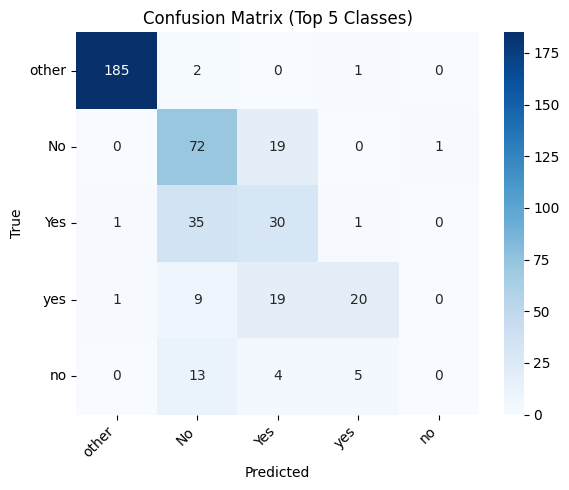

In [31]:
# 10.1) Gather calibrated probabilities & predicted labels on val set
all_calib_logits = all_val_logits.to(device) / T  # [N_val, 11]
all_calib_preds = all_calib_logits.argmax(dim=1).cpu().numpy()
all_true_labels = all_val_labels.numpy()

# 10.2) Compute top‐1 and top‐5 on calibrated logits
def global_topk_accuracy(calib_logits, true_labels, k=5):
    topk_inds = torch.topk(calib_logits, k, dim=1).indices.cpu().numpy()  # [N_val, k]
    matches = sum((true_labels[i] in topk_inds[i]) for i in range(len(true_labels)))
    return matches / len(true_labels)

val_top1 = (all_calib_preds == all_true_labels).sum() / len(all_true_labels)
val_top5 = global_topk_accuracy(all_calib_logits, all_true_labels, k=5)
print(f"\nCalibrated Val Top-1 Acc: {val_top1:.4f}, Top-5 Acc: {val_top5:.4f}")

# 10.3) Classification Report (11 classes)
unique_ids   = sorted(set(all_true_labels) | set(all_calib_preds))
target_names = [id2answer[i] for i in unique_ids]
print("\nClassification Report (Collapsed 11 classes):")
print(classification_report(
    all_true_labels,
    all_calib_preds,
    labels=unique_ids,
    target_names=target_names,
    zero_division=0
))

# 10.4) Confusion Matrix for Top 5 Most Frequent Labels
val_label_counts = Counter(all_true_labels)
top5_ids = [lbl for lbl,_ in val_label_counts.most_common(5)]
cm = confusion_matrix(all_true_labels, all_calib_preds, labels=top5_ids)
labels5 = [id2answer[i] for i in top5_ids]

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=labels5, yticklabels=labels5,
    cmap='Blues'
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Top 5 Classes)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [32]:
def get_attention_overlay(image: Image.Image, layer: int = -1) -> Image.Image:
    """
    Returns a PIL Image with the ViT CLS‐token attention heatmap overlayed.
    * image: PIL RGB, already resized to 224×224 or larger (we use transform inside).
    * layer: index of the ViT layer to visualize (default last).
    """
    # 11.1) Reload ViT with attentions enabled
    vit_cfg = ViTConfig.from_pretrained(
        'google/vit-base-patch16-224-in21k',
        output_attentions=True,
        attn_implementation="eager"
    )
    attn_vit = ViTModel.from_pretrained(
        'google/vit-base-patch16-224-in21k',
        config=vit_cfg
    ).to(device)
    # Copy weights from our main model’s vision backbone
    attn_vit.load_state_dict(model.vit.state_dict(), strict=False)
    attn_vit.eval()

    # 11.2) Preprocess image
    with torch.no_grad():
        pix = val_image_transform(image).unsqueeze(0).to(device)  # [1,3,224,224]
        outputs = attn_vit(pixel_values=pix)
        # Get attentions: tuple of length num_layers, each [1, heads, seq_len, seq_len]
        attn = outputs.attentions[layer][0]  # [heads, seq_len, seq_len]

    # 11.3) Compute CLS→patch attention, average heads
    cls_attn = attn[:, 0, 1:]  # [heads, num_patches]
    cls_mean = cls_attn.mean(0).cpu().numpy()  # [num_patches]

    # 11.4) Reshape into grid (14×14 for 224/16)
    G = int(np.sqrt(cls_mean.shape[0]))          # e.g. 14
    attn_map = cls_mean.reshape(G, G)            # [14,14]

    # 11.5) Upsample to image resolution by tiling
    H, W = image.size
    up = H // G
    attn_up = np.kron(attn_map, np.ones((up, up)))  # [H, W]

    # 11.6) Normalize to [0,1]
    attn_norm = (attn_up - attn_up.min()) / (attn_up.max() - attn_up.min() + 1e-8)

    # 11.7) Blend with original image
    overlay = np.array(image).astype(np.float32) / 255.0  # [H, W, 3]
    cmap = plt.get_cmap('jet')
    heatmap = cmap(attn_norm)[:, :, :3]                 # [H, W, 3] in 0–1
    blended = 0.5 * overlay + 0.5 * heatmap
    blended = np.clip(blended * 255, 0, 255).astype(np.uint8)
    return Image.fromarray(blended)


In [35]:
!pip install -q pyngrok streamlit


In [36]:
from pyngrok import ngrok
import os


In [38]:
# Install pyngrok if you haven’t already
!pip install -q pyngrok

from pyngrok import ngrok

# 3.1) Paste your authtoken here (replace <YOUR_AUTH_TOKEN> with the actual token)
ngrok.set_auth_token("2xqnyGu85VUmor4C6Hopag8S1HM_3SWaL4kr7wQQSJ1AvNiVu")

# 3.2) Now you can start a tunnel on port 8501
public_url = ngrok.connect(8501).public_url
print("▶ Your Streamlit app will be available at:", public_url)


▶ Your Streamlit app will be available at: https://610d-34-143-229-198.ngrok-free.app


In [41]:
!streamlit run app.py --server.port 8501 --server.headless true &> /dev/null &
